**Note: Run this file with tensorflow version 2.9.1 to supressing warnings.**

# <font size = 6.5, color=#0096FF>Classifying Images of Road Traffic Signs</font>

# <font size= 5.8, color=#0096FF>Data Preparation</font>

In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from PIL import Image
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow_addons as tfa
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Conv2D, AveragePooling2D, MaxPooling2D
from keras.layers import Dense, Flatten
from keras.models import Sequential

In [2]:
import warnings 
warnings.filterwarnings("ignore")

In [3]:
# unzipping the dataset of images
with zipfile.ZipFile('../trafficsigns_dataset.zip', 'r') as zip_ref:
        zip_ref.extractall('../')

In [4]:
# checking for corrupt images, invalid image types
data = "../trafficsigns_dataset"
# selecting only folders with shape names
sign_shapes = [shape for shape in os.listdir(f'{data}/') if '.' not in shape]
for sign_shape in sign_shapes:
    # selecting only folders with sign-type names for each shape
    sign_types = [sign_type for sign_type in os.listdir(f'{data}/{sign_shape}') if '.' not in sign_type]
    for sign_type in sign_types:
        imgs = [img for img in os.listdir(f'{data}/{sign_shape}/{sign_type}')]
        for image_name in imgs:
            if image_name.endswith('.png'):       
                try:
                    # opening the image file
                    img = Image.open(f'{data}/{sign_shape}/{sign_type}/' + image_name) 
                    # verifying that it is an image
                    img.verify() 
                except (IOError, SyntaxError) as e:
                    # printing out the names of corrupt files
                    print(image_name, " seems to be corrupted") 
            else:
                print("Invalid image type for the file ", image_name)

Invalid image type for the file  .DS_Store


We can ignore the above file since it is a hidden file created by the system. We will filter it out by ignoring the files which do not have a '.png' extension. <br>
No corrupted images were found in the dataset

Creating a csv file for conveniently splitting the images later

In [5]:
# collecting image names and their classes (sign-shapes)
# to fill the csv file
header = ['img_path','sign_shape','sign_type']
csv_data = []
# mapping values for target column (sign_shape)
shape_to_int = {'diamond':'0', 'hex':'1', 'square':'2', 'triangle':'3', 'round':'4'}
sign_to_int = {}
number = -1

for sign_shape in sign_shapes:
    img_class = shape_to_int[sign_shape]
    sign_types = [sign_type for sign_type in os.listdir(f'{data}/{sign_shape}') if '.' not in sign_type]
    for sign_type in sign_types:
        number = number + 1
        sign_to_int[sign_type] = number
        imgs = [img for img in os.listdir(f'{data}/{sign_shape}/{sign_type}') if img.endswith('.png')]
        for img in imgs:
            row = []
            img_path = f'{data}/{sign_shape}/{sign_type}/' + img
            row.append(img_path)
            row.append(img_class)
            row.append(number)
            csv_data.append(row)

In [6]:
sign_to_int

{'rightofway': 0,
 'stop': 1,
 'laneend': 2,
 'parking': 3,
 'continue': 4,
 'crossing': 5,
 'giveway': 6,
 'warning': 7,
 'traveldirection': 8,
 'limitedtraffic': 9,
 'speed': 10,
 'roundabout': 11,
 'noentry': 12,
 'noparking': 13,
 'bicycle': 14,
 'trafficdirective': 15}

In [7]:
# writing collected data to the csv file
with open('../trafficsigns_dataset/trafficsigns_dataset.csv', 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)
        # write the header
        writer.writerow(header)
        # write multiple rows
        writer.writerows(csv_data)

# <font size= 5.8, color=#0096FF>Data Exploration</font>

In [8]:
# converting list of shapes to string
shapes_str = ', '.join(sign_shapes)
print("All shapes in the dataset: " + shapes_str + "\nNumber of shapes in the dataset: " + str(len(sign_shapes)))

All shapes in the dataset: diamond, hex, square, triangle, round
Number of shapes in the dataset: 5


In [9]:
total_image_count = 0
total_types_count = 0
imgs_per_shape = {}
types_per_shape = {}
imgs_per_type = {}
# selecting only folders with sign-type names for each shape
for sign_shape in sign_shapes:
    imgs_per_shape[sign_shape] = 0
    sign_types = [sign_type for sign_type in os.listdir(f'{data}/{sign_shape}') if '.' not in sign_type]
    # counting no.of.images in this sign-type
    for sign_type in sign_types:
        imgs = [img for img in os.listdir(f'{data}/{sign_shape}/{sign_type}') if img.endswith('.png')]
        imgs_per_type[sign_type] = len(imgs)
        imgs_per_shape[sign_shape] = imgs_per_shape[sign_shape] + len(imgs)
        total_image_count = total_image_count + len(imgs)
        
    total_types_count = total_types_count + len(sign_types)
    types_per_shape[sign_shape] = len(sign_types)
    # converting list of sign-types to string
    types_str = ', '.join(sign_types)
    print("Sign-types for the shape " + sign_shape + ": " + types_str)
    print("Number of sign-types: " + str(len(sign_types)) + "\n")
    
print("Total no.of.images in the dataset: " + str(total_image_count))
print("Total no.of.sign-types in the dataset: " + str(total_types_count))

Sign-types for the shape diamond: rightofway
Number of sign-types: 1

Sign-types for the shape hex: stop
Number of sign-types: 1

Sign-types for the shape square: laneend, parking, continue, crossing
Number of sign-types: 4

Sign-types for the shape triangle: giveway, warning
Number of sign-types: 2

Sign-types for the shape round: traveldirection, limitedtraffic, speed, roundabout, noentry, noparking, bicycle, trafficdirective
Number of sign-types: 8

Total no.of.images in the dataset: 3699
Total no.of.sign-types in the dataset: 16


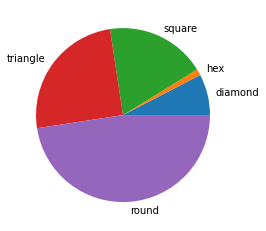

In [10]:
# distribution of no.of.images per shape
shapes = list(imgs_per_shape.keys())
count = list(imgs_per_shape.values())
plt.pie(count, labels = shapes)
plt.show()

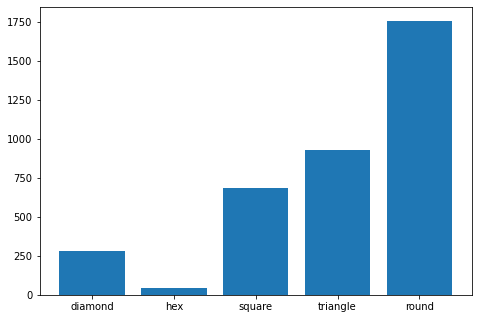

In [11]:
# distribution of no.of.images per shape
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(shapes,count)
plt.show()

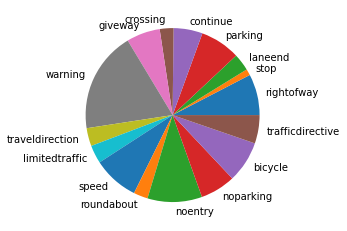

In [12]:
# distribution of no.of.images per sign-type
types = list(imgs_per_type.keys())
count = list(imgs_per_type.values())
plt.pie(count, labels = types)
plt.show()

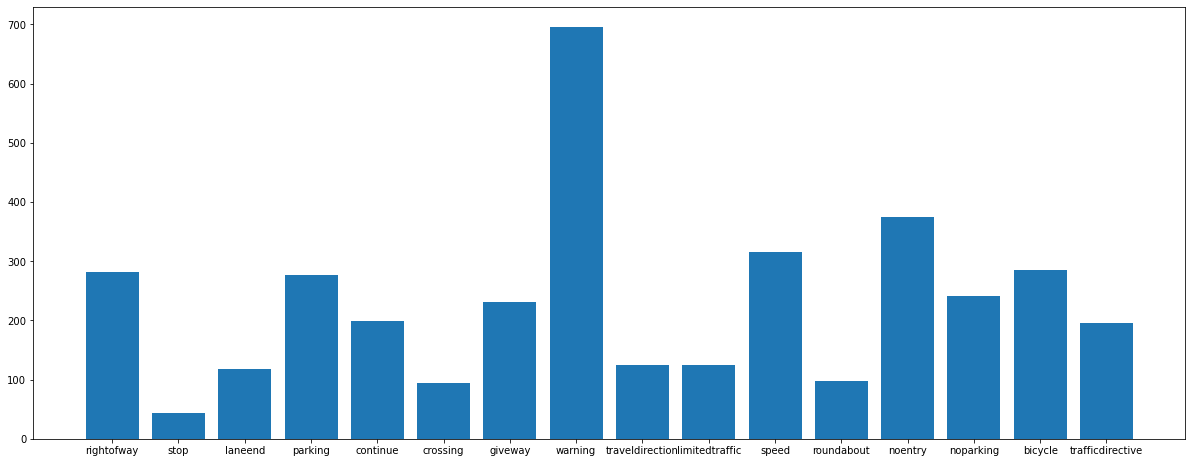

In [13]:
# distribution of no.of.images per sign-type
fig = plt.figure(figsize=(16,6))
ax = fig.add_axes([0,0,1,1])
ax.bar(types,count)
plt.show()

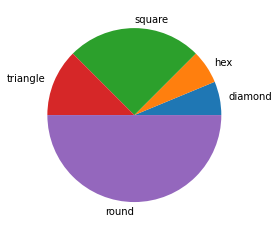

In [14]:
# display distribution of no.of.types in each shape 
shapes = list(types_per_shape.keys())
count = list(types_per_shape.values())
plt.pie(count, labels = shapes)
plt.show()

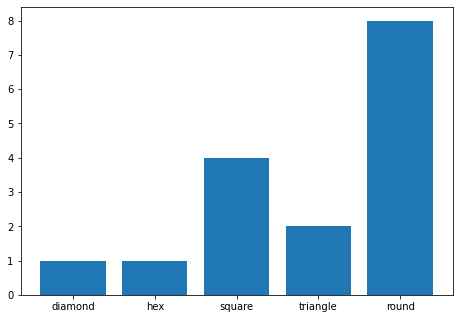

In [15]:
# display distribution of no.of.types in each shape 
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(shapes,count)
plt.show()

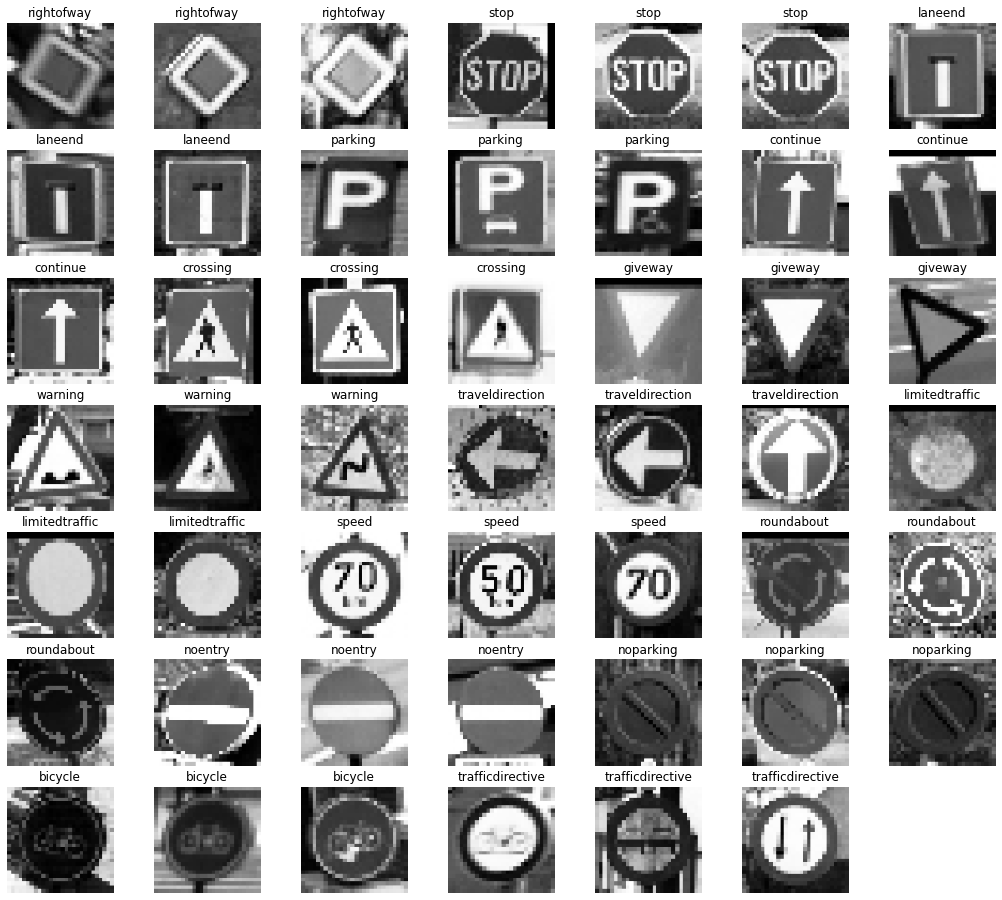

In [16]:
# randomly selecting and displaying 3 images of each sign-type
fig = plt.figure(figsize = (18,16))
index = 0
for sign_shape in sign_shapes:
    sign_types = [sign_type for sign_type in os.listdir(f'{data}/{sign_shape}') if '.' not in sign_type]
    for sign_type in sign_types:
        imgs = [img for img in os.listdir(f'{data}/{sign_shape}/{sign_type}') if img.endswith('.png')]
        random_imgs = np.random.choice(imgs, 3, replace = False)
        for i in range(3):
            index = index + 1
            img = f'{data}/{sign_shape}/{sign_type}/{random_imgs[i]}'
            label = sign_type
            # plotting 7 x 7 image matrix
            ax = fig.add_subplot(7, 7, index)
            fn = image.load_img(img, target_size = (100,100), color_mode='grayscale')
            plt.imshow(fn, cmap='Greys_r')
            plt.title(label)
            plt.axis('off')

plt.show()            

In [17]:
# creating a matrix of all the images of a given sign-type
def create_img_matrix(sign_shape, sign_type, imgs_list):
    dir_path = f'{data}/{sign_shape}/{sign_type}/'
    size = (28,28)
    # iterating through each image file
    for img_name in imgs_list:
        img_path = dir_path + img_name
        img = image.load_img(img_path, target_size = size, color_mode = 'grayscale')
        # coverting image to a matrix (3D Numpy array)
        img_matrix = image.img_to_array(img)
        # turning 3D Numpy array into a 1D array
        img_matrix = [img_matrix.ravel()]
        try:
            # concatenate image matrix to another matrix 
            # containing all images of the sign-type
            full_matrix = np.concatenate((full_matrix, img_matrix))
        except NameError: 
            # if full matrix doesn't exist, create one
            full_matrix = img_matrix
    return full_matrix

In [18]:
# creating an average image for a given sign-type
def create_mean_img(full_matrix):
    size = (28,28)
    # calculate the mean
    mean_img = np.mean(full_matrix, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    return mean_img

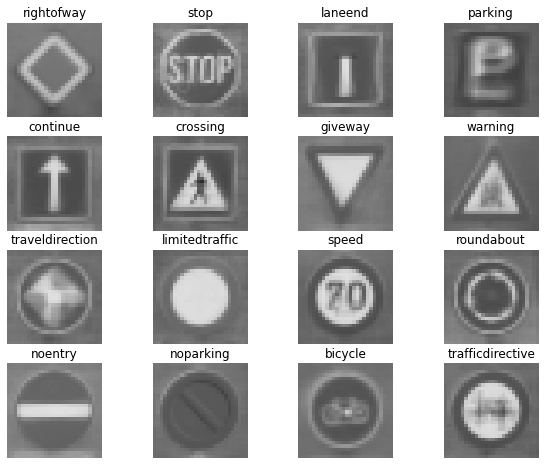

In [19]:
# plotting average images of all sign-types
fig = plt.figure(figsize = (10,8))
index = 0
for sign_shape in sign_shapes:
    sign_types = [sign_type for sign_type in os.listdir(f'{data}/{sign_shape}') if '.' not in sign_type]
    # randomly selecting and displaying 3 images of each sign-type
    for sign_type in sign_types:        
        imgs_list = [img for img in os.listdir(f'{data}/{sign_shape}/{sign_type}') if img.endswith('.png')]
        full_matrix = create_img_matrix(sign_shape, sign_type, imgs_list)
        mean_img = create_mean_img(full_matrix)
        label = sign_type
        # plotting 4 x 4 image matrix
        index = index + 1
        ax = fig.add_subplot(4, 4, index)
        plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
        plt.title(label)
        plt.axis('off')

plt.show()

# <font size= 5.8, color=#0096FF>Splitting the data</font>

In [20]:
# splitting the data into train, test, and validation sets
# train: 70, test: 15, val:15
df = pd.read_csv('../trafficsigns_dataset/trafficsigns_dataset.csv')

train_data, test_data = train_test_split(df, test_size=0.15, random_state=136)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=136)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 2672, Val Data: 472, Test Data: 555


In [21]:
df.shape

(3699, 3)

In [22]:
df.dtypes

img_path      object
sign_shape     int64
sign_type      int64
dtype: object

# <font size= 5.8, color=#0096FF>Preprocessing the data</font>

In [23]:
# converting the target column 'sign_shape' from int to string
train_data['sign_shape'] = train_data['sign_shape'].astype('str')
val_data['sign_shape'] = val_data['sign_shape'].astype('str')
test_data['sign_shape'] = test_data['sign_shape'].astype('str')

# Normalising the pixel values to 0-1
train_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# taking batch size that exactly divides the total no.of.images
# to avoid missing out on any images
batch_size = 37

train_generator = train_gen.flow_from_dataframe(
        dataframe=train_data,
        directory=None,
        x_col="img_path",
        y_col="sign_shape",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

val_generator = val_gen.flow_from_dataframe(
        dataframe=val_data,
        directory=None,
        x_col="img_path",
        y_col="sign_shape",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

test_generator = test_gen.flow_from_dataframe(
        dataframe=test_data,
        directory=None,
        x_col="img_path",
        y_col="sign_shape",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

Found 2672 validated image filenames belonging to 5 classes.
Found 472 validated image filenames belonging to 5 classes.
Found 555 validated image filenames belonging to 5 classes.


# <font size = 6.5, color=#0096FF>Classifying Images: Sign-shape</font>

# <font size= 5.8, color=#0096FF>Model 1: LeNet Architecture</font>

**The following architecture of LeNet is being followed for the first model:**
<img src="./LeNetArchitecture.png" alt="LeNet architecture" width="600"/>
LeNet Architecture: A Complete Guide. (n.d.). Kaggle.com. Retrieved May 26, 2022, from https://www.kaggle.com/code/blurredmachine/lenet-architecture-a-complete-guide/notebook

In [24]:
# Supressing all the warnings for the purpose of documentation
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [25]:
@tf.autograph.experimental.do_not_convert
def fit_model(model, epochs, verbose):
    history = model.fit(train_generator, 
                    validation_data = val_generator, 
                    epochs=epochs, verbose=verbose)
    return history

In [26]:
# plots two graphs:
# 1.training and val loss per each epoch
# 2.training and val f1-score per each epoch
def plot_loss_f1_graphs(history):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], 'r--')
    plt.plot(history.history['val_loss'], 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(history.history['f1_score'], 'r--')
    plt.plot(history.history['val_f1_score'], 'b--')
    plt.xlabel("epochs")
    plt.ylabel("f1_score")
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.show()

In [27]:
# calculates the average validation loss
# of all epochs
def print_avg_loss(history):
    val_loss = history.history['val_loss']
    avg_val_loss = sum(val_loss)/len(val_loss)
    print("Average validation loss: ", str(avg_val_loss))
    
# calculates the average f1-score
# of all epochs
def print_avg_f1(history):
    f1_scores = history.history['val_f1_score']
    avg_f1 = sum(f1_scores)/len(f1_scores)
    print("Average validation F1 score: ", str(avg_f1))
    
# calculates the average train loss
# of all epochs
def print_avg_train_loss(history):
    loss = history.history['loss']
    avg_loss = sum(loss)/len(loss)
    print("Average train loss: ", str(avg_loss))
    
# calculates the average train f1-score
# of all epochs
def print_avg_train_f1(history):
    f1_scores = history.history['f1_score']
    avg_f1 = sum(f1_scores)/len(f1_scores)
    print("Average train F1 score: ", str(avg_f1))

In [28]:
model_lenet = Sequential()
# output of each layer: [(n + 2p - f/s)+1]**2 x no.of.filters 
# where n = size of image, p = padding, f = filter size, s = stride

# output/input of next layer = [(28 + 0 - 5/1)+1]**2 x 6 = (24)**2 x 6 = 24 x 24 x 6 
model_lenet.add(Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(28, 28, 1), strides=(1,1) ))
# output/input of next layer = [(24 + 0 - 2/2)+1]**2 x 6 = (12)**2 x 6 = 12 x 12 x 6 
model_lenet.add(AveragePooling2D(pool_size=(2, 2), strides=(2,2)))

# output/input of next layer = [(12 + 0 - 5/1)+1]**2 x 16 = (8)**2 x 16 = 8 x 8 x 16 
model_lenet.add(Conv2D(16, kernel_size=(5, 5), activation='tanh', strides=(1,1) ))
# output/input of next layer = [(8 + 0 - 2/2)+1]**2 x 16 = (4)**2 x 16 = 4 x 4 x 16 
# now that the img size cannot be decreased any further, there is no need
# for another conv layer, we will stop here
model_lenet.add(AveragePooling2D(pool_size=(2, 2), strides=(2,2)))

model_lenet.add(Flatten())
# input = 4 x 4 x 16 = 256
model_lenet.add(Dense(84, activation='tanh'))
# units = 5 = no.of.classes in the dataset
model_lenet.add(Dense(5, activation='softmax'))

In [29]:
# describing the f1 score needed as metric for the model with the help of
# tensorflow addons (tfa) since tf.keras.Model.fit() does not provide
# f1 score as a metric for evaluation

f1_score = tfa.metrics.F1Score(num_classes= 5, average= 'weighted')

# loss function: CategoricalCrossentropy because we are doing multiclass classification
# optimizer: Adam because faster computation time and less parameters for tuning
model_lenet.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer= tf.keras.optimizers.Adam(),
              metrics=[f1_score])

# After a lot of trial and error, epochs = 200 seemed to produce 
# the least avg loss with the highest accuracy
lenet_history = fit_model(model_lenet, 200, 0)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

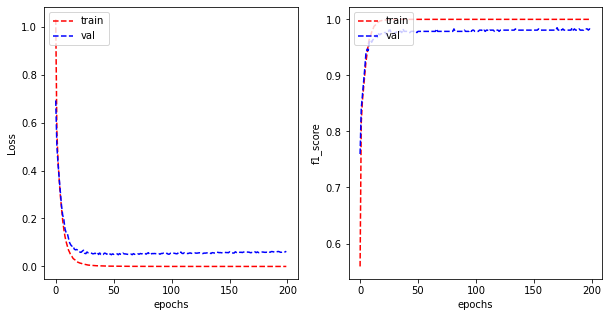

In [30]:
plot_loss_f1_graphs(lenet_history)

In [31]:
print_avg_loss(lenet_history)
print_avg_f1(lenet_history)

Average validation loss:  0.0711188198439777
Average validation F1 score:  0.9753039520978928


In [32]:
print_avg_train_loss(lenet_history)
print_avg_train_f1(lenet_history)

Average train loss:  0.020499082801352982
Average train F1 score:  0.9933230850100517


# <font size= 5.8, color=#0096FF>Model 2: Modified LeNet Architecture</font>

Changing activation function from 'tanh' to 'relu' and using 'Maxpooling' instead of 'AveragePooling', to see if the model improves:

In [33]:
model_lenet2 = Sequential()
# output of each layer: [(n + 2p - f/s)+1]**2 x no.of.filters 
# where n = size of image, p = padding, f = filter size, s = stride

# output/input of next layer = [(28 + 0 - 5/1)+1]**2 x 6 = (24)**2 x 6 = 24 x 24 x 6 
model_lenet2.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1), strides=(1,1) ))
# output/input of next layer = [(24 + 0 - 2/2)+1]**2 x 6 = (12)**2 x 6 = 12 x 12 x 6 
model_lenet2.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

# output/input of next layer = [(12 + 0 - 5/1)+1]**2 x 16 = (8)**2 x 16 = 8 x 8 x 16 
model_lenet2.add(Conv2D(16, kernel_size=(5, 5), activation='relu', strides=(1,1) ))
# output/input of next layer = [(8 + 0 - 2/2)+1]**2 x 16 = (4)**2 x 16 = 4 x 4 x 16 
# now that the img size cannot be decreased any further, there is no need
# for another conv layer, we will stop here
model_lenet2.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

model_lenet2.add(Flatten())
# input = 4 x 4 x 16 = 256
model_lenet2.add(Dense(84, activation='relu'))
# units = 5 = no.of.classes in the dataset
model_lenet2.add(Dense(5, activation='softmax'))

In [34]:
f1_score = tfa.metrics.F1Score(num_classes= 5, average= 'weighted')

model_lenet2.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer= tf.keras.optimizers.Adam(),
              metrics=[f1_score])

# After a lot of trial and error, epochs = 200 seemed to produce 
# the least avg loss with the highest accuracy
lenet2_history = fit_model(model_lenet2, 200, 0)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


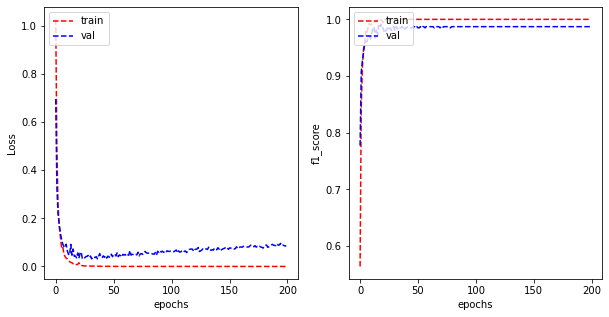

In [35]:
plot_loss_f1_graphs(lenet2_history)

In [36]:
print_avg_loss(lenet2_history)
print_avg_f1(lenet2_history)

Average validation loss:  0.07036659617908299
Average validation F1 score:  0.9836278560757638


We can see that there is a decrease in the average loss and increase in the average F1 score. Hence, this model 2 is better than model 1.

In [37]:
print_avg_train_loss(lenet2_history)
print_avg_train_f1(lenet2_history)

Average train loss:  0.012869441991386026
Average train F1 score:  0.9955876544117928


# <font size= 5.8, color=#0096FF>Model 3: VGG Architecture</font>

**The following architecture of VGG-16 is being followed for this model:**
<img src="./VGG-16Architecture.jpeg" alt="VGG architecture" width="800"/>
Ferguson, M., Ak, R., Lee, Y.-T., & Law, K. (2017, December). Automatic localization of casting defects with convolutional neural networks. https://www.researchgate.net/publication/322512435_Automatic_localization_of_casting_defects_with_convolutional_neural_networks

In [38]:
model_vgg = Sequential()
# output of each layer: [(n + 2p - f/s)+1]**2 x no.of.filters 
# where n = size of image, p = padding, f = filter size, s = stride

# output/input of next layer = [(28 + 0 - 3/1)+1]**2 x 64 = (26)**2 x 64 = 26 x 26 x 64 
model_vgg.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28, 28, 1), strides=(1,1) ))
# output/input of next layer = [(26 + 0 - 3/1)+1]**2 x 64 = (24)**2 x 64 = 24 x 24 x 64 
model_vgg.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', strides=(1,1) ))
# output/input of next layer = [(24 + 0 - 2/2)+1]**2 x 64 = (12)**2 x 64 = 12 x 12 x 64
model_vgg.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

# output/input of next layer = [(12 + 0 - 3/1)+1]**2 x 128 = (10)**2 x 128 = 10 x 10 x 128
model_vgg.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28, 28, 1), strides=(1,1) ))
# output/input of next layer = [(10 + 0 - 3/1)+1]**2 x 128 = (8)**2 x 128 = 8 x 8 x 128
model_vgg.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', strides=(1,1) ))
# output/input of next layer = [(8 + 0 - 2/2)+1]**2 x 128 = (4)**2 x 128 = 4 x 4 x 128
model_vgg.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

# output/input of next layer = [(4 + 0 - 3/1)+1]**2 x 256 = (2)**2 x 256 = 2 x 2 x 256
# now that the img size cannot be decreased any further, there is no need
# for another conv layer, we will stop here
model_vgg.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', strides=(1,1) ))
# output/input of next layer = [(2 + 0 - 2/2)+1]**2 x 256 = (1)**2 x 256 = 1 x 1 x 256
model_vgg.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

model_vgg.add(Flatten())
# input = 1 x 1 x 256 = 256
model_vgg.add(Dense(128, activation='relu'))
model_vgg.add(Dense(128, activation='relu'))
# units = 5 = no.of.classes in the dataset
model_vgg.add(Dense(5, activation='softmax'))


In [39]:
# describing the f1 score needed as metric for the model with the help of
# tensorflow addons (tfa) since tf.keras.Model.fit() does not provide
# f1 score as a metric for evaluation

f1_score = tfa.metrics.F1Score(num_classes= 5, average= 'weighted')

model_vgg.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer= tf.keras.optimizers.Adam(),
              metrics=[f1_score])

vgg_history = fit_model(model_vgg, 200, 0)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


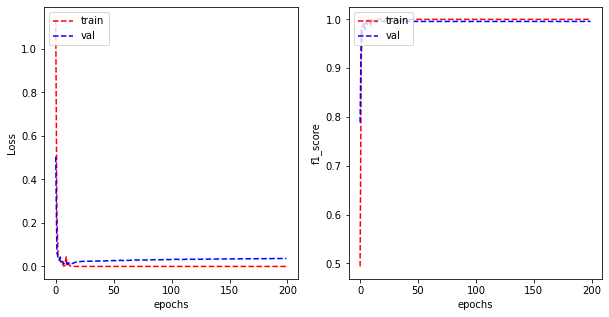

In [40]:
plot_loss_f1_graphs(vgg_history)

In [41]:
print_avg_loss(vgg_history)
print_avg_f1(vgg_history)

Average validation loss:  0.032943731346167626
Average validation F1 score:  0.9943981224298477


In [42]:
print_avg_train_loss(vgg_history)
print_avg_train_f1(vgg_history)

Average train loss:  0.007946032514687295
Average train F1 score:  0.9967414432764053


In [43]:
# save models and architectures to single files
model_lenet.save("./model_lenet.h5")
print("Saved model_lenet to disk")
model_lenet2.save("./model_lenet2.h5")
print("Saved model_lenet2 to disk")
model_vgg.save("./model_vgg.h5")
print("Saved model_vgg to disk")

Saved model_lenet to disk
Saved model_lenet2 to disk
Saved model_vgg to disk


# <font size= 5.8, color=#0096FF>Model Evaluation</font>

In [44]:
@tf.autograph.experimental.do_not_convert
def print_confusion_matrix(model):

    preds = list()
    labels = list()

    for i in range (len(test_generator)):
        (x, y) = test_generator[i]
        y_pred = model.predict(x, verbose=0)
        preds.append(np.argmax(y_pred, axis=1))
        labels.append(np.argmax(y, axis=1))

    y_pred = np.concatenate(preds)
    y_true = np.concatenate(labels)
    print(classification_report(y_true[:, None], y_pred[:, None]))
    print(confusion_matrix(y_true[:, None], y_pred[:, None]))

In [45]:
model_lenet.evaluate(test_generator)

15/15 [==============================] - 0s 12ms/step - loss: 0.0264 - f1_score: 0.9945


[0.026382271200418472, 0.9945213794708252]

In [46]:
model_lenet2.evaluate(test_generator)

15/15 [==============================] - 0s 12ms/step - loss: 0.1340 - f1_score: 0.9820


[0.1339867264032364, 0.9820070266723633]

In [47]:
model_vgg.evaluate(test_generator)

15/15 [==============================] - 0s 23ms/step - loss: 0.0401 - f1_score: 0.9964


[0.04014171287417412, 0.9963901042938232]

In [48]:
model_1 = load_model("./model_lenet.h5")
model_2 = load_model("./model_lenet2.h5")
model_3 = load_model("./model_vgg.h5")

In [49]:
print_confusion_matrix(model_1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        47
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00       114
           3       1.00      1.00      1.00       132
           4       0.99      1.00      0.99       254

    accuracy                           0.99       555
   macro avg       1.00      0.99      0.99       555
weighted avg       0.99      0.99      0.99       555

[[ 44   0   0   0   3]
 [  0   8   0   0   0]
 [  0   0 114   0   0]
 [  0   0   0 132   0]
 [  0   0   0   0 254]]


In [50]:
print_confusion_matrix(model_2)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
              precision    recall  f1-score   support

           0       0.94      0.98      0.96        47
           1       1.00      1.00      1.00         8
           2       0.97      0.99      0.98       114
           3       0.98      0.96      0.97       132
           4       0.99      0.99      0.99       254

    accuracy                           0.98       555
   macro avg       0.98      0.98      0.98       555
weighted avg       0.98      0.98      0.98       555

[[ 46   0   0   0   1]
 [  0   8   0   0   0]
 [  0   0 113   1   0]
 [  1   0   3 127   1]
 [  2   0   0   1 251]]


In [51]:
print_confusion_matrix(model_3)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        47
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00       114
           3       0.99      1.00      1.00       132
           4       1.00      1.00      1.00       254

    accuracy                           1.00       555
   macro avg       1.00      0.99      1.00       555
weighted avg       1.00      1.00      1.00       555

[[ 46   0   0   0   1]
 [  0   8   0   0   0]
 [  0   0 114   0   0]
 [  0   0   0 132   0]
 [  0   0   0   1 253]]


# <font size = 6.5, color=#0096FF>Classifying Images: Sign-type</font>

**We will now use transfer learning to load models we made to classify sign-shape and use them to classify sign-types.**

# <font size= 5.8, color=#0096FF>Preprocessing the data</font>

In [52]:
# converting the target column 'sign_type' from int to string
train_data['sign_type'] = train_data['sign_type'].astype('str')
val_data['sign_type'] = val_data['sign_type'].astype('str')
test_data['sign_type'] = test_data['sign_type'].astype('str')

# Normalising the pixel values to 0-1
train_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# taking batch size that exactly divides the total no.of.images
# to avoid missing out on any images
batch_size = 37

train_generator = train_gen.flow_from_dataframe(
        dataframe=train_data,
        directory=None,
        x_col="img_path",
        y_col="sign_type",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

val_generator = val_gen.flow_from_dataframe(
        dataframe=val_data,
        directory=None,
        x_col="img_path",
        y_col="sign_type",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

test_generator = test_gen.flow_from_dataframe(
        dataframe=test_data,
        directory=None,
        x_col="img_path",
        y_col="sign_type",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

Found 2672 validated image filenames belonging to 16 classes.
Found 472 validated image filenames belonging to 16 classes.
Found 555 validated image filenames belonging to 16 classes.


# <font size= 5.8, color=#0096FF>Model 1: Transfer Learning: LeNet</font>

In [53]:
# loading the lenet model
lenet_model = load_model("./model_lenet2.h5")
# freezing all layers
lenet_model.trainable = False
# summarizing the model
lenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 24, 24, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 6)        0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 16)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 84)               

In [54]:
# The first layer of the loaded model
inputs = lenet_model.layers[0].input
# The second last layer of the loaded model
outputs = lenet_model.layers[-2].output
# Defining the final layer of the new model
final_outputs = Dense(16, activation='softmax')(outputs)

In [55]:
new_model_lenet = tf.keras.Model(inputs=inputs, outputs=final_outputs)
new_model_lenet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2_input (InputLayer)  [(None, 28, 28, 1)]      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 6)        0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 16)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 256)               0     

In [56]:
f1_score = tfa.metrics.F1Score(num_classes= 16, average= 'weighted')

new_model_lenet.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer= tf.keras.optimizers.Adam(),
              metrics=[f1_score])

In [57]:
new_lenet_history = fit_model(new_model_lenet, 25, 0)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


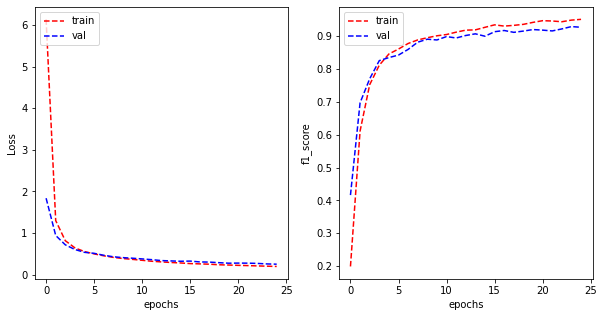

In [58]:
plot_loss_f1_graphs(new_lenet_history)

In [59]:
print_avg_loss(new_lenet_history)
print_avg_f1(new_lenet_history)

Average validation loss:  0.4533868581056595
Average validation F1 score:  0.8637591290473938


In [60]:
# save model and architecture to single file
new_model_lenet.save("./new_model_lenet.h5")

# <font size= 5.8, color=#0096FF>Model 2: Transfer Learning: Modified LeNet</font>

Since we did not achieve as good accuracy as we did for sign-shapes, we will unfreeze some layers to train our models.

In [61]:
# loading the model
lenet_model = load_model("./model_lenet2.h5")

# freezing only the first two layers
for i in range(2):
    lenet_model.layers[i].trainable = False

# summarizing the model
lenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 24, 24, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 6)        0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 16)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 84)               

In [62]:
# The first layer of the loaded model
inputs = lenet_model.layers[0].input
# The second layer of the loaded model
outputs = lenet_model.layers[1].output
# Layers to be trained
layer_1 = Conv2D(16, kernel_size=(5, 5), activation='relu', strides=(1,1) )(outputs)
layer_2 = MaxPooling2D(pool_size=(2, 2), strides=(2,2), name = "max_pooling2d_1")(layer_1)
layer_3 = Flatten()(layer_2)
layer_4 = Dense(84, activation='relu')(layer_3)
# Defining the final layer of the new model for 16 classes
final_outputs = Dense(16, activation='softmax')(layer_4)

In [63]:
new_model_lenet2 = tf.keras.Model(inputs=inputs, outputs=final_outputs)
new_model_lenet2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2_input (InputLayer)  [(None, 28, 28, 1)]      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 6)        0         
 )                                                               
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 16)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 256)               0   

In [64]:
f1_score = tfa.metrics.F1Score(num_classes= 16, average= 'weighted')

new_model_lenet2.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer= tf.keras.optimizers.Adam(),
              metrics=[f1_score])

In [65]:
new_lenet2_history = fit_model(new_model_lenet2, 25, 0)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


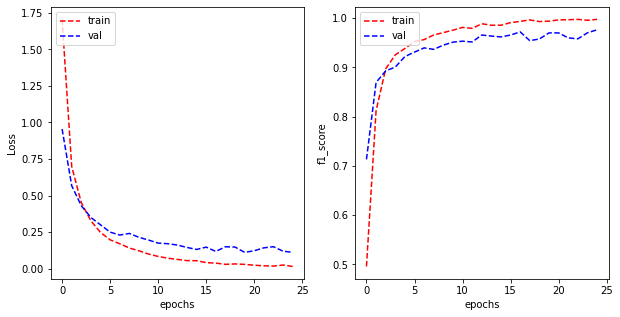

In [66]:
plot_loss_f1_graphs(new_lenet2_history)

In [67]:
print_avg_loss(new_lenet2_history)
print_avg_f1(new_lenet2_history)

Average validation loss:  0.23354301869869232
Average validation F1 score:  0.9382673454284668


In [68]:
# save model and architecture to single file
new_model_lenet2.save("./new_model_lenet2.h5")

# <font size= 5.8, color=#0096FF>Model 3: Transfer Learning: VGG</font>

In [69]:
# loading the model
vgg_model = load_model("./model_vgg.h5")
# freezing all layers
vgg_model.trainable = False

# summarizing the model
vgg_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                  

In [70]:
# The first layer of the loaded model
inputs = vgg_model.layers[0].input
# The second last layer of the loaded model
outputs = vgg_model.layers[-2].output
# Defining the final layer of the new model
final_outputs = Dense(16, activation='softmax')(outputs)

In [71]:
new_model_vgg = tf.keras.Model(inputs=inputs, outputs=final_outputs)
new_model_vgg.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4_input (InputLayer)  [(None, 28, 28, 1)]      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 128)       147584    
                                                           

In [72]:
f1_score = tfa.metrics.F1Score(num_classes= 16, average= 'weighted')

new_model_vgg.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer= tf.keras.optimizers.Adam(),
              metrics=[f1_score])

In [73]:
new_vgg_history = fit_model(new_model_vgg, 25, 0)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


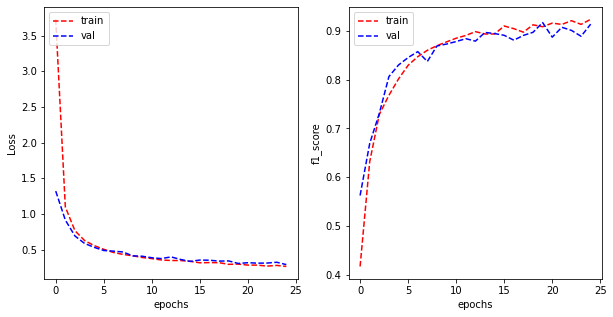

In [74]:
plot_loss_f1_graphs(new_vgg_history)

In [75]:
print_avg_loss(new_vgg_history)
print_avg_f1(new_vgg_history)

Average validation loss:  0.4546737337112427
Average validation F1 score:  0.8512464165687561


In [76]:
# save model and architecture to single file
new_model_vgg.save("./new_model_vgg.h5")

# <font size= 5.8, color=#0096FF>Model 4: Transfer Learning: Improved VGG</font>

Since we did not achieve as good accuracy as we did for sign-shapes, we will unfreeze some layers to train our models.

In [77]:
# loading the model
vgg_model2 = load_model("./model_vgg.h5")

# freezing only the first six layers
for i in range(6):
    vgg_model2.layers[i].trainable = False

# summarizing the model
vgg_model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                  

In [78]:
# The first layer of the loaded model
inputs = vgg_model2.layers[0].input
# The sixth of the loaded model
outputs = vgg_model2.layers[5].output
# Layers to be trained
layer_1 = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', strides=(1,1) )(outputs)
layer_2 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(layer_1)
layer_3 = Flatten()(layer_2)
layer_4 = Dense(128, activation='relu')(layer_3)
layer_5 = Dense(128, activation='relu')(layer_4)
# Defining the final layer of the new model
final_outputs = Dense(16, activation='softmax')(layer_5)

In [79]:
new_model_vgg2 = tf.keras.Model(inputs=inputs, outputs=final_outputs)
new_model_vgg2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4_input (InputLayer)  [(None, 28, 28, 1)]      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 128)       147584    
                                                           

In [80]:
f1_score = tfa.metrics.F1Score(num_classes= 16, average= 'weighted')

new_model_vgg2.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer= tf.keras.optimizers.Adam(),
              metrics=[f1_score])

In [81]:
new_vgg2_history = fit_model(new_model_vgg2, 25, 0)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


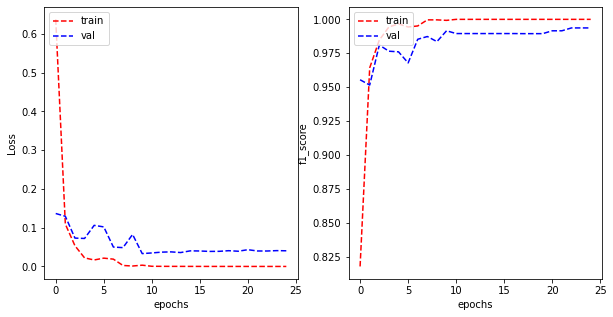

In [82]:
plot_loss_f1_graphs(new_vgg2_history)

In [83]:
print_avg_loss(new_vgg2_history)
print_avg_f1(new_vgg2_history)

Average validation loss:  0.056894979625940326
Average validation F1 score:  0.9846213793754578


In [84]:
# save model and architecture to single file
new_model_vgg2.save("./new_model_vgg2.h5")

# <font size= 5.8, color=#0096FF>Model Evaluation</font>

In [85]:
new_model_lenet.evaluate(test_generator)

15/15 [==============================] - 0s 12ms/step - loss: 0.3057 - f1_score: 0.9228


[0.3056762218475342, 0.922777533531189]

In [86]:
new_model_lenet2.evaluate(test_generator)

15/15 [==============================] - 0s 12ms/step - loss: 0.1209 - f1_score: 0.9692


[0.12088111788034439, 0.9692496061325073]

In [87]:
new_model_vgg.evaluate(test_generator)

15/15 [==============================] - 0s 23ms/step - loss: 0.3294 - f1_score: 0.9086


[0.32935264706611633, 0.9085723161697388]

In [92]:
new_model_vgg2.evaluate(test_generator)

15/15 [==============================] - 0s 29ms/step - loss: 0.0452 - f1_score: 0.9893


[0.045193884521722794, 0.9892747402191162]

In [88]:
print_confusion_matrix(new_model_lenet)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        47
           1       1.00      1.00      1.00         8
           2       0.86      0.91      0.88        46
           3       1.00      0.76      0.87        17
           4       0.94      0.94      0.94        51
           5       0.75      0.88      0.81        34
           6       0.95      0.93      0.94        40
           7       0.96      0.79      0.87        33
           8       0.78      1.00      0.88        14
           9       0.97      1.00      0.99        39
          10       1.00      0.88      0.94        41
          11       0.84      0.80      0

In [89]:
print_confusion_matrix(new_model_lenet2)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        47
           1       1.00      1.00      1.00         8
           2       0.93      0.93      0.93        46
           3       1.00      0.94      0.97        17
           4       1.00      0.94      0.97        51
           5       0.97      0.97      0.97        34
           6       0.98      1.00      0.99        40
           7       0.92      1.00      0.96        33
           8       1.00      1.00      1.00        14
           9       0.97      1.00      0.99        39
          10       1.00      0.95      0.97        41
          11       0.94      0.85      0

In [90]:
print_confusion_matrix(new_model_vgg)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        47
           1       1.00      1.00      1.00         8
           2       0.86      0.91      0.88        46
           3       0.94      0.88      0.91        17
           4       0.98      0.86      0.92        51
           5       0.80      0.94      0.86        34
           6       0.84      0.93      0.88        40
           7       0.85      0.67      0.75        33
           8       0.81      0.93      0.87        14
           9       0.88      0.97      0.93        39
          10       0.97      0.76      0.85        41
          11       0.83      0.95      0

In [93]:
print_confusion_matrix(new_model_vgg2)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        47
           1       1.00      1.00      1.00         8
           2       1.00      0.98      0.99        46
           3       1.00      1.00      1.00        17
           4       1.00      0.96      0.98        51
           5       0.92      1.00      0.96        34
           6       1.00      1.00      1.00        40
           7       1.00      1.00      1.00        33
           8       0.93      1.00      0.97        14
           9       1.00      1.00      1.00        39
          10       1.00      0.98      0.99        41
          11       1.00      0.95      0